# Binary Task - Emotion Recognition

In [11]:
import time
import os
import cv2

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import datasets, classifiers and performance metrics
from sklearn import svm, metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score


%matplotlib inline

# setting user chosen vars
images_dir = './new_dataset'
labels_filename = 'attribute_list.csv'
# user choses grey scale or not, 0 for yes, 1 for no
grey_scale = 1


data_preprocessing: 
- https://datascience.stackexchange.com/questions/26881/data-preprocessing-should-we-normalise-images-pixel-wise
- https://stackoverflow.com/questions/41428868/image-preprocessing-in-deep-learning
- https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258
- https://stackoverflow.com/questions/50584353/image-mean-subtraction/50585147 - mean subtraction

- image rescaling (zooming) will not be necessary as the frontal faces are all zommed in already and cover the full frontal face without any further processing needed. It is true however that some images do contain some abnormal noise in the background, behind the faces (or even occlusive elemnts on the face itself - like watermarks or arms covering part of the mouth and such)

In [2]:
# Import whole pre-processed Dataset (training and test)

# lists keep the order
full_dataset = []
full_labels = []

# collect labels
df = pd.read_csv(labels_filename, skiprows=1, index_col='file_name')
newdf = df[df.columns[2]] 

# collect pre-processed images and sort them to labels
for (root, dirs, dat_files) in os.walk('{0}'.format(images_dir)):
     
    for file in dat_files:
        # image grayscaling at import
        img = cv2.imread('{0}/{1}'.format(images_dir, file), grey_scale)
        # image equalisation
        # rescaling image (you can use cv2)
        res = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
        # turn to float for zero centering
        res = res.astype(float)
        full_dataset.append(res)
        full_labels.append(int(file[:-4]))

# only select rows of interest (none outliers) and only keep 'smiling' feature to be evaluated
full_labels = newdf.loc[full_labels]
full_labels = full_labels.values.tolist() 

# now both of our dataset and labels are ordered 

# numpy array conversion
full_dataset = np.array(full_dataset)
full_labels = np.array(full_labels)

print('full dataset of shape:', full_dataset.shape)
print('full labels of shape:', full_labels.shape)

full dataset of shape: (4546, 128, 128, 3)
full labels of shape: (4546,)


In [3]:
# plt.imshow(full_dataset[0])
full_dataset[0]

array([[[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       ..., 
       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 

In [4]:
# Reshuffling data (for extra randomness)
X_data, Y_data = shuffle(full_dataset, full_labels, random_state=0)

print('X_data of shape:', X_data.shape)
print('Y_data of shape:', Y_data.shape)

X_data of shape: (4546, 128, 128, 3)
Y_data of shape: (4546,)


- https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

In [5]:
# perform train and test split (random state set to 1 to ensure same distribution accross different sets)
# this split is obviously case specific! but cross validation allows us to avoid over-fitting so lets make sure we have a validation set ready.
# Since the dataset is not extrememly large i'll be using a 60/20/20 split, meaning more or less 1000 validation and test examples and 3000 training examples, to be tested: 75/10/15
# in this case we are a little less concerned since we are evaluating smiles which are present in every case, unlike glasses 
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# sanity check
print('X_train of shape:', X_train.shape)
print('y_train of shape:', y_train.shape)
print('X_val of shape:', X_val.shape)
print('y_val of shape:', y_val.shape)
print('X_test of shape:', X_test.shape)
print('y_test of shape:', y_test.shape)

X_train of shape: (2908, 128, 128, 3)
y_train of shape: (2908,)
X_val of shape: (728, 128, 128, 3)
y_val of shape: (728,)
X_test of shape: (910, 128, 128, 3)
y_test of shape: (910,)


X_train of shape: (2908, 49152)
X_val of shape: (728, 49152)
X_test of shape: (910, 49152)
[ 187.0849381   190.80914718  194.27063274  188.85350757  192.59731774
  196.07255846  189.66093535  193.36176066  196.85591472  190.05570839]


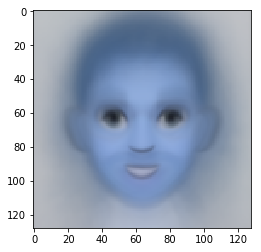

In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# sanity check
print('X_train of shape:', X_train.shape)
print('X_val of shape:', X_val.shape)
print('X_test of shape:', X_test.shape)

# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((128,128,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [8]:
classifier = svm.SVC(C=1, kernel='linear',cache_size=8000,probability=False)

start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

classifier.fit(X_train, y_train)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2018-12-26 17:05:28.779253
Stop learning 2018-12-26 17:09:21.441722
Elapsed learning 0:03:52.662469


In [9]:
# Now predict the value of the test
expected = y_test
predicted = classifier.predict(X_test)


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
      
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

# plot_confusion_matrix(cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))

Classification report for classifier SVC(C=1, cache_size=8000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

         -1       0.73      0.80      0.76       177
          1       0.95      0.93      0.94       733

avg / total       0.91      0.90      0.91       910


Confusion matrix:
[[142  35]
 [ 53 680]]
Accuracy=0.9032967032967033


This was a good first try, let us now proceed to a grid search for hyper-parameterisation, these best parameters will then be used for Kfold validation. Reminder: our dataset is not extremely large so we need to proceed with caution when it comes to train / validation / test separation. We also need to make sure that the latter have the same sort of distribution for best results. It comes without saying that the split should always be the same accross experiments. Moreover, the size of the validation and test sets should be big enough for results to be representative of the performance of our model. The validation set will be taken off of our training set, the latter will be used for hyperparameterization. The test set is not used for the latter to avoid obvious overfitting, which i'm pretty sure a lot of people will have forgotten about (common pitfall). The test set will be used for inference once we have found our ideal parameters and hyper-params for our classifier/model.

In [9]:
# creating dummy SVM classifier for hyperparameterization
classifier = svm.SVC()

In [ ]:
n_folds = 5
# choosing different parameter combinations to try
param_grid = {'C': [0.01, 0.1, 1, 10], 
              'gamma': [0.00002, 0.0001, 0.001, 0.01],
              'kernel': ['rbf', 'linear'],
             }

# type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)


# run grid search
start_time = dt.datetime.now()
print('Start grid search at {}'.format(str(start_time)))

grid_search = GridSearchCV(classifier, param_grid, cv=n_folds, scoring=acc_scorer, n_jobs=4)
grid_obj = grid_search.fit(X_train, y_train)

# set the best classifier found for rbf
clf = grid_obj.best_estimator_

end_time = dt.datetime.now() 
print('Stop grid search {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed grid search time {}'.format(str(elapsed_time)))


# fit the best alg to the training data
start_time = dt.datetime.now()
print('Start learning with best params at {}'.format(str(start_time)))

clf.fit(X_train, y_train)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning time {}'.format(str(elapsed_time)))


# predict using validation set
predictions = clf.predict(X_val)
print(accuracy_score(y_val, predictions))

Start grid search at 2018-12-26 19:28:29.852039


In [12]:
# get cv_results from grid_obj

In [ ]:
# do actual inference with test data